In [1]:
import numpy as np
import astropy as ap
from astropy import units as u
import matplotlib.pyplot as plt
import ugradio
import time

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Functions to Use

    ifm.stow
    ifm.maintenance
    ifm.get_pointing where is telescope now
    ifm.point(alt,az) where do you want it to point
    hpm.read_voltage
    hpm.start_recording(dt)
    hpm.get_recording_data()
    hpm.end_recording()
    ugradio.coord.sunpos(jd)
    ugradio.coord.moonpos(jd,lat,lon,alt)
    ugradio.coord.get_altaz(ra, dec, jd, lat, lon, alt)
    ugradio.coord.precess(ra, dec, jd, equinox)

In [2]:
# ifm = ugradio.interf.Interferometer()
# hpm = ugradio.hp_multi.HP_Multimeter()


In [3]:
# Crab Nebula
print('Crab Nebula coordinates are {}'.format(ap.coordinates.SkyCoord('05:34:31.95', '+22:00:52.1', unit = (u.hourangle, u.deg))))

# Orion Nebula
print('Orion Nebula coordinates are {}'.format(ap.coordinates.SkyCoord('05:35:17.3', '-05:23:28', unit = (u.hourangle, u.deg))))

# M17
print('M17 coordinates are {}'.format(ap.coordinates.SkyCoord('18:20:26', '-16:10.6', unit = (u.hourangle, u.deg))))

# Cygnus A 
print('CygA coordinates are {}'.format(ap.coordinates.SkyCoord('19:59:28.357', '+40:44:02.1', unit = (u.hourangle, u.deg))))

# Cas A
print('Cas A coordinates {}'.format(ap.coordinates.SkyCoord('23:23:24', '+58:48.9', unit = (u.hourangle, u.deg))))

Crab Nebula coordinates are <SkyCoord (ICRS): (ra, dec) in deg
    ( 83.633125,  22.01447222)>
Orion Nebula coordinates are <SkyCoord (ICRS): (ra, dec) in deg
    ( 83.82208333, -5.39111111)>
M17 coordinates are <SkyCoord (ICRS): (ra, dec) in deg
    ( 275.10833333, -16.17666667)>
CygA coordinates are <SkyCoord (ICRS): (ra, dec) in deg
    ( 299.86815417,  40.73391667)>
Cas A coordinates <SkyCoord (ICRS): (ra, dec) in deg
    ( 350.85,  58.815)>


In [2]:
def julianDayArray(hrs, dt, initUnixT):
    interval = hrs*60./dt
    secInt = dt*60.
    jds = []
    for i in range(int(interval)):
        jds.append(ugradio.timing.julian_date(initUnixT + secInt*i))
    # actual julian data to put into alt az functions
    jds = np.array(jds)
    # start from 0 and convert to hours for plot
    jdHrs = []
    jdHrs = (jds - jds[0])*24
    return jds, np.array(jdHrs)

In [14]:
3.3*60/3

66.0

In [18]:
jull, jullHrs = julianDayArray(12, 5, 1520627066.146196)

In [29]:
start_t = time.time()
aa, zz = findAltAz(350.85,  58.815, jull)
print(time.time() - start_t)

15.5763609409


In [15]:
def findAltAz(ra, dec, jd_array):
    altArr = []
    azArr = []
    for j in jd_array:
        raP, decP = ugradio.coord.precess(ra, dec, jd = j)
        alt, az = ugradio.coord.get_altaz(raP, decP, jd =j)
        altArr.append(alt)
        azArr.append(az)
    return np.array(altArr), np.array(azArr)

In [8]:
def moonAltAz(jd_array):
    altArr = []
    azArr = []
    for j in jd_array:
        raM,decM = ugradio.coord.moonpos(jd = j)
        alt, az = ugradio.coord.get_altaz(raM, decM, jd = j)
        altArr.append(alt)
        azArr.append(az)
    return np.array(altArr), np.array(azArr)

In [9]:
def sunAltAz(jd_array):
    altArr = []
    azArr = []
    for j in jd_array:
        raS, decS = ugradio.coord.sunpos(jd = j)
        alt, az = ugradio.coord.get_altaz(raS, decS, jd = j)
        altArr.append(alt)
        azArr.append(az)
    return np.array(altArr), np.array(azArr)

In [10]:
def corrections(altitude, azimuth):
    for al, az, i in zip(altitude, azimuth, range(len(altitude))):
        if az < 90:
            azimuth[i] = az + 180
            altitude[i] = abs(180 - altitude[i])
        elif az > 300:
            azimuth[i] = az - 180
            altitude[i] = abs(180 - altitude[i])
    return altitude, azimuth

In [33]:
with open('test.txt', 'w') as pointFile:
    pointFile.write('{}\t{}\t{}\t{}\n'.format('wAlt', 'wAz', 
                                              'eAlt', 'eAz'))
    
    for a, z in zip(aa, zz):
        pointFile.write('{}\t{}\t{}\t{}\n'.format(a, a, 
                                                  z, z))

In [13]:
def collect_data(ra, dec, hrs, dt, n, dataFile, pointfileName):
    with open('{}'.format(pointfileName), 'w') as pointFile:
        pointFile.write('{}\t{}\t{}\t{}\n'.format('westAltitude', 'westAzimuth', 'eastAltitude', 'eastAzimuth'))
        
        unix = ugradio.timing.unix_time()
        jds, jdsHr = julianDayArray(hrs, dt, unix)
        alts, azs = findAltAz(ra, dec, jds)
        correctAlt, correctAz = corrections(alts, azs)

        ct = 0
        for al, az in zip(correctAlt, correctAz):
            ifm.point(al, az)
            get_point = ifm.get_pointing()
            valAltAz = get_point.values()
            pointFile.write('{}\t{}\t{}\t{}\n'.format(valAltAz[0][0], valAltAz[0][1], valAltAz[1][0], valAltAz[1][1]))

            hpm.start_recording(n)
            start_time = time.time()
            time.sleep(dt*60)
            current_time = time.time()
            if current_time - start_time >= dt*60:
                volts, times = hpm.end_recording()
                np.savez('{}_{}'.format(dataFile, ct), v = volts, tt = times)   
                ct += 1

In [30]:
jdArr, jdHrss = julianDayArray(.1,3,ugradio.timing.unix_time())
tAlt, tAz = findAltAz(350.85,  58.815, jdArr)
print(tAlt, tAz)
cAlt, cAz = corrections(tAlt, tAz)
print(cAlt, cAz)

(array([ 32.24666852,  32.60969758]), array([ 37.61786487,  37.78115258]))
(array([ 147.75333148,  147.39030242]), array([ 217.61786487,  217.78115258]))


In [36]:
ifm.get_pointing()

{'ant_e': (147.65625, 217.620605469), 'ant_w': (147.727539062, 217.645703125)}

In [23]:
a = np.load('fuck_0.npz')['v']
c = np.load('fuck_1.npz')['v']

In [24]:
b = np.load('fuck_0.npz')['tt']
d = np.load('fuck_1.npz')['tt']

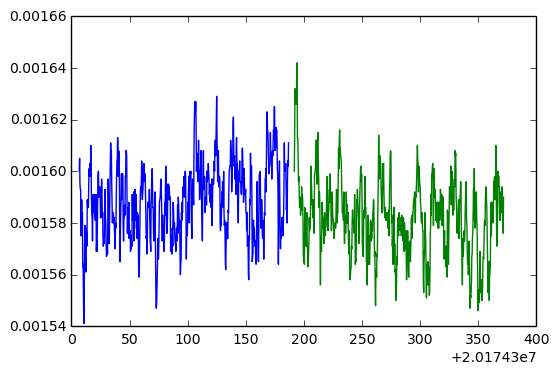

In [25]:
plt.plot(b-1.5e9, a)
plt.plot(d-1.5e9, c)
# plt.xlim(0,100)

In [ ]:
# hpm.get_recording_status()
hpm.end_recording()

In [ ]:
ugradio.timing.unit_time()

In [ ]:
# Julian day times for 24 hours at 15 minute intervals starting March 4th at 3 am
jd_times, jd_72hrs = julianDayArray(20, 15, ugradio.timing.unit_time())
# jd_moon, jd_24moon = julianDayArray(24, 3, 1520166599.7119844)

In [ ]:
# Find Coordinates for Objects of Interest
crabAlt, crabAz = findAltAz(83.633125,  22.01447222, jd_times)
orionAlt, orionAz = findAltAz(83.82208333, -5.39111111, jd_times)
M17Alt, M17Az = findAltAz(275.10833333, -16.17666667, jd_times)
CygAlt, CybAz = findAltAz(299.86815417,  40.73391667, jd_times)
CasAlt, CasAz = findAltAz(350.85,  58.815, jd_3min)
# moonAlt, moonAz = moonAltAz(jd_moon)
# sunAlt, sunAz = sunAltAz(jd_moon)

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(jd_72hrs+3, crabAlt, label = 'crab Nebula')
plt.plot(jd_72hrs+3, orionAlt, label = 'Orion')
plt.plot(jd_72hrs+3, M17Alt, label = 'M17')
plt.plot(jd_72hrs+3, CygAlt, label = 'Cygnus')
plt.plot(jd_72hrs+4.5, CasAlt, label = 'Cas')
# plt.plot(jd_24moon+3, moonAlt, label = 'Moon', c = 'navy')
# plt.plot(jd_24moon+3, sunAlt, 'y', label = 'Sun')
plt.ylim(0,100)
plt.xlim(3,35)
plt.legend(loc = 'lower right')
plt.xlabel('PST TIME')
plt.ylabel('ALTITUDE')
plt.title('March 4th')

In [ ]:
with open('{}.txt'.format('test'), 'w') as pointFile: 
    pointFile.write('{}\n{}'.format('alt', 'az'))

In [ ]:
def collect_moon_now():
    start_t = ugradio.timing.unix_time()
    moonRA, moonDEC = ugradio.coord.moonpos()
    moonALT, moonAZ = ugradio.coord.get_altaz(moonRA, moonDEC)
    ifm.point(moonALT, moonAZ)
    print('Where am I pointing?', ifm.get_pointing(), 'and where is the moon?', moonALT, moonAZ)
    hpm.start_recording(0.2)
    
    V, t = hpm.get_recording_data()

In [ ]:
print(time.time())
print(ugradio.timing.unix_time())

In [ ]:
moonRA, moonDEC = ugradio.coord.moonpos()
moonALT, moonAZ = ugradio.coord.get_altaz(moonRA, moonDEC)

In [ ]:
moonALT, moonAZ

In [ ]:
ugradio.coord.sunpos()

In [ ]:
ifm.get_pointing()

In [ ]:
ifm.point(moonALT, moonAZ)

In [ ]:
hpm.start_recording(0.3)

In [ ]:
901*.15

In [ ]:
hpm.get_recording_status()

In [ ]:
# hpm.end_recording()

In [ ]:
# V_025, t_025 = hpm.get_recording_data()

In [ ]:
# V_015, t_015 = hpm.get_recording_data()

In [ ]:
# V_005, t_005 = hpm.get_recording_data()

In [ ]:
V_01, t_01 = hpm.get_recording_data()

In [ ]:
# V_1, t_1 = hpm.get_recording_data()

In [ ]:
V_02, t_02 = hpm.get_recording_data()

In [ ]:
V_03, t_03 = hpm.get_recording_data()

In [ ]:
plt.plot(t_03, V_03)
plt.plot()

In [ ]:
plt.plot(t_025, V_025)
plt.plot()

In [ ]:
plt.plot(t_015, V_015)

In [ ]:
plt.plot(t_005, V_005)

In [ ]:
plt.plot(t_01, V_01)

In [ ]:
plt.plot(t_02,V_02)

In [ ]:
t_02

In [ ]:
plt.plot(t_1, V_1)